<h1 align="center">Evaluating and Improving Machine Learning Models</h1>

###### By: [jihad akbar](https://github.com/jihadakbr)
###### You can see this notebook clearly using this link [nbviewer.org](https://nbviewer.org/github/jihadakbr/evaluating-and-improving-machine-learning-models/blob/main/evaluating-and-improving-machine-learning-models.ipynb).

<h1>Credit</h1>

<div class="alert alert-block alert-success" style="margin-top: 20px">
<p><i><b>This project was completed as a part of the Honors portion of the <a href="https://www.coursera.org/learn/advanced-learning-algorithms" target="_blank">Advanced Learning Algorithms</a> Course on <a href="https://www.coursera.org/" target="_blank">Coursera</a>. </b></i></p>
<p><i><b>Credit to DeepLearning.AI, Stanford, and the Coursera platform for providing the course materials and guidance.</b></i></p>

<div id="toc"><h1>Table of Contents</h1></div>

- [ 1 - Packages ](#1)
- [ 2 - Evaluating a Learning Algorithm (Polynomial Regression)](#2)
  - [ 2.1 Splitting your data set](#2.1)
  - [ 2.2 Error calculation for model evaluation, linear regression](#2.2)
    - [ Exercise 1](#ex01)
  - [ 2.3 Compare performance on training and test data](#2.3)
- [ 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> ](#3)
  - [ 3.1 Plot Train, Cross-Validation, Test](#3.1)
  - [ 3.2 Finding the optimal degree](#3.2)
  - [ 3.3 Tuning Regularization.](#3.3)
  - [ 3.4 Getting more data: Increasing Training Set Size (m)](#3.4)
- [ 4 - Evaluating a Learning Algorithm (Neural Network)](#4)
  - [ 4.1 Data Set](#4.1)
  - [ 4.2 Evaluating categorical model by calculating classification error](#4.2)
    - [ Exercise 2](#ex02)
- [ 5 - Model Complexity](#5)
  - [ Exercise 3](#ex03)
  - [ 5.1 Simple model](#5.1)
    - [ Exercise 4](#ex04)
- [ 6 - Regularization](#6)
  - [ Exercise 5](#ex05)
- [ 7 - Iterate to find optimal regularization value](#7)
  - [ 7.1 Test](#7.1)


_**NOTE:** To prevent errors from the autograder, you are not allowed to edit or delete non-graded cells in this notebook . Please also refrain from adding any new cells. 
**Once you have passed this assignment** and want to experiment with any of the non-graded code, you may follow the instructions at the bottom of this notebook._

<a name="1"></a>
## 1 - Packages 

<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- [scikitlearn](https://scikit-learn.org/stable/) is a basic library for data mining
- [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning.

In [3]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import * 

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

<a name="2"></a>
## 2 - Evaluating a Learning Algorithm (Polynomial Regression)
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

<img align="Right" src="./images/C2_W3_TrainingVsNew.png"  style=" width:350px; padding: 10px 20px ; "> Let's say you have created a machine learning model and you find it *fits* your training data very well. You're done? Not quite. The goal of creating the model was to be able to predict values for <span style="color:blue">*new* </span> examples. 

How can you test your model's performance on new data before deploying it?   
The answer has two parts:
* Split your original data set into "Training" and "Test" sets. 
    * Use the training data to fit the parameters of the model
    * Use the test data to evaluate the model on *new* data
* Develop an error function to evaluate your model.

<a name="2.1"></a>
### 2.1 Splitting your data set
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

Lectures advised reserving 20-40% of your data set for testing. Let's use an `sklearn` function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to perform the split. Double-check the shapes after running the following cell.

In [4]:
# Generate some data
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


#### 2.1.1 Plot Train, Test sets
You can see below the data points that will be part of training (in red) are intermixed with those that the model is not trained on (test). This particular data set is a quadratic function with noise added. The "ideal" curve is shown for reference.

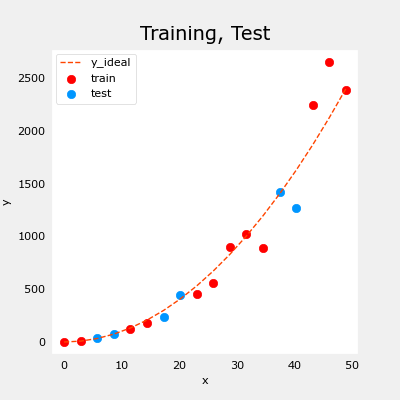

In [5]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="2.2"></a>
### 2.2 Error calculation for model evaluation, linear regression
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

When *evaluating* a linear regression model, you average the squared error difference of the predicted values and the target values.

$$ J_\text{test}(\mathbf{w},b) = 
            \frac{1}{2m_\text{test}}\sum_{i=0}^{m_\text{test}-1} ( f_{\mathbf{w},b}(\mathbf{x}^{(i)}_\text{test}) - y^{(i)}_\text{test} )^2 
            \tag{1}
$$

<a name="ex01"></a>
### Exercise 1
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

Below, create a function to evaluate the error on a data set for a linear regression model.

In [6]:
# UNQ_C1
# GRADED CELL: eval_mse
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    
    for i in range(m):
        err_i = ( (yhat[i] - y[i])**2 ) 
        err  += err_i 
    
    err = err / (2*m)  
    return(err)

In [7]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
eval_mse(y_hat, y_tmp)

# BEGIN UNIT TEST
test_eval_mse(eval_mse)   
# END UNIT TEST

 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>

    
```python
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
        err_i  = ( (yhat[i] - y[i])**2 ) 
        err   += err_i                                                                
    err = err / (2*m)                    
    return(err)
``` 

<a name="2.3"></a>
### 2.3 Compare performance on training and test data
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

Let's build a high degree polynomial model to minimize training error. This will use the linear_regression functions from `sklearn`. The code is in the imported utility file if you would like to see the details. The steps below are:
* create and fit the model. ('fit' is another name for training or running gradient descent).
* compute the error on the training data.
* compute the error on the test data.

In [8]:
# create a model in sklearn, train on training data
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# predict on training data, find training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# predict on test data, find error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

The computed error on the training set is substantially less than that of the test set. 

In [9]:
print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

training err 58.01, test err 171215.01


The following plot shows why this is. The model fits the training data very well. To do so, it has created a complex function. The test data was not part of the training and the model does a poor job of predicting on this data.  
This model would be described as 1) is overfitting, 2) has high variance 3) 'generalizes' poorly.

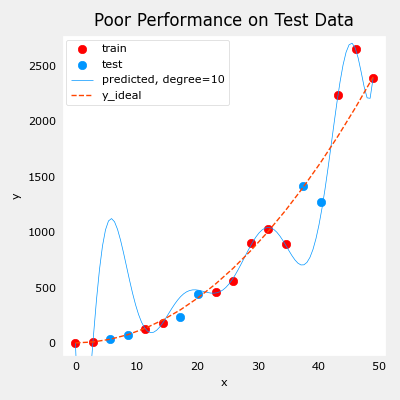

In [10]:
# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

The test set error shows this model will not work well on new data. If you use the test error to guide improvements in the model, then the model will perform well on the test data... but the test data was meant to represent *new* data.
You need yet another set of data to test new data performance.

The proposal made during lecture is to separate data into three groups. The distribution of training, cross-validation and test sets shown in the below table is a typical distribution, but can be varied depending on the amount of data available.

| data             | % of total | Description |
|------------------|:----------:|:---------|
| training         | 60         | Data used to tune model parameters $w$ and $b$ in training or fitting |
| cross-validation | 20         | Data used to tune other model parameters like degree of polynomial, regularization or the architecture of a neural network.|
| test             | 20         | Data used to test the model after tuning to gauge performance on new data |


Let's generate three data sets below. We'll once again use `train_test_split` from `sklearn` but will call it twice to get three splits:

In [11]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


<a name="3"></a>
## 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> 
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

 Above, it was clear the degree of the polynomial model was too high. How can you choose a good value? It turns out, as shown in the diagram, the training and cross-validation performance can provide guidance. By trying a range of degree values, the training and cross-validation performance can be evaluated. As the degree becomes too large, the cross-validation performance will start to degrade relative to the training performance. Let's try this on our example.

<a name="3.1"></a>
### 3.1 Plot Train, Cross-Validation, Test
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

You can see below the datapoints that will be part of training (in red) are intermixed with those that the model is not trained on (test and cv).

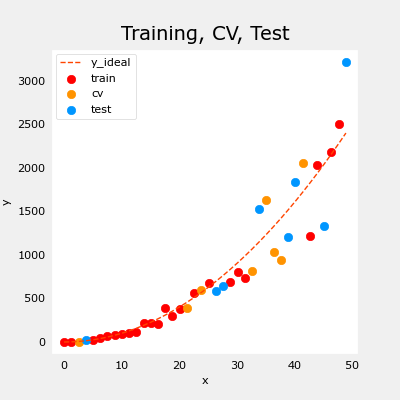

In [12]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="3.2"></a>
### 3.2 Finding the optimal degree
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

In previous labs, you found that you could create a model capable of fitting complex curves by utilizing a polynomial (See Course1, Week2 Feature Engineering and Polynomial Regression Lab).  Further, you demonstrated that by increasing the *degree* of the polynomial, you could *create* overfitting. (See Course 1, Week3, Over-Fitting Lab). Let's use that knowledge here to test our ability to tell the difference between over-fitting and under-fitting.

Let's train the model repeatedly, increasing the degree of the polynomial each iteration. Here, we're going to use the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) linear regression model for speed and simplicity.

In [14]:
max_degree = 9
err_train = np.zeros(max_degree)    
err_cv = np.zeros(max_degree)      
x = np.linspace(0,int(X.max()),100)  
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)
    
optimal_degree = np.argmin(err_cv)+1

<font size="4">Let's plot the result:</font>

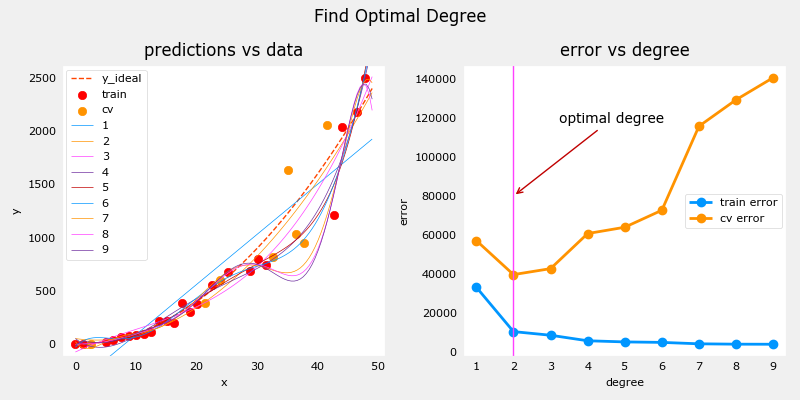

In [15]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

The plot above demonstrates that separating data into two groups, data the model is trained on and data the model has not been trained on, can be used to determine if the model is underfitting or overfitting. In our example, we created a variety of models varying from underfitting to overfitting by increasing the degree of the polynomial used. 
- On the left plot, the solid lines represent the predictions from these models. A polynomial model with degree 1 produces a straight line that intersects very few data points, while the maximum degree hews very closely to every data point. 
- on the right:
    - the error on the trained data (blue) decreases as the model complexity increases as expected
    - the error of the cross-validation data decreases initially as the model starts to conform to the data, but then increases as the model starts to over-fit on the training data (fails to *generalize*).     
    
It's worth noting that the curves in these examples as not as smooth as one might draw for a lecture. It's clear the specific data points assigned to each group can change your results significantly. The general trend is what is important.

<a name="3.3"></a>
### 3.3 Tuning Regularization.
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

In previous labs, you have utilized *regularization* to reduce overfitting. Similar to degree, one can use the same methodology to tune the regularization parameter lambda ($\lambda$).

Let's demonstrate this by starting with a high degree polynomial and varying the regularization parameter.

In [16]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv) 

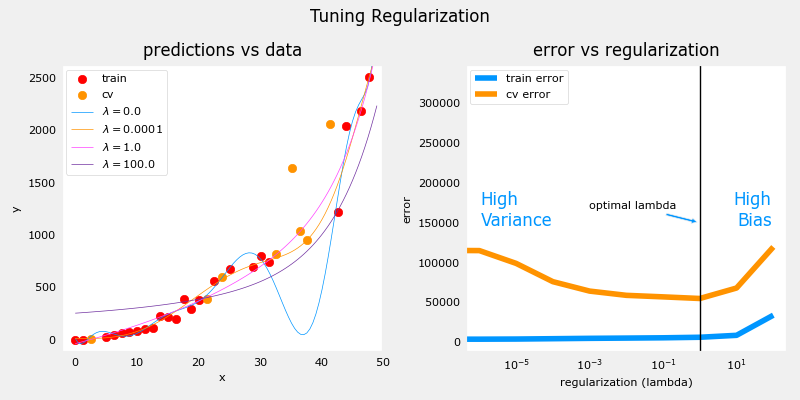

In [17]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

Above, the plots show that as regularization increases, the model moves from a high variance (overfitting) model to a high bias (underfitting) model. The vertical line in the right plot shows the optimal value of lambda. In this example, the polynomial degree was set to 10. 

<a name="3.4"></a>
### 3.4 Getting more data: Increasing Training Set Size (m)
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

When a model is overfitting (high variance), collecting additional data can improve performance. Let's try that here.

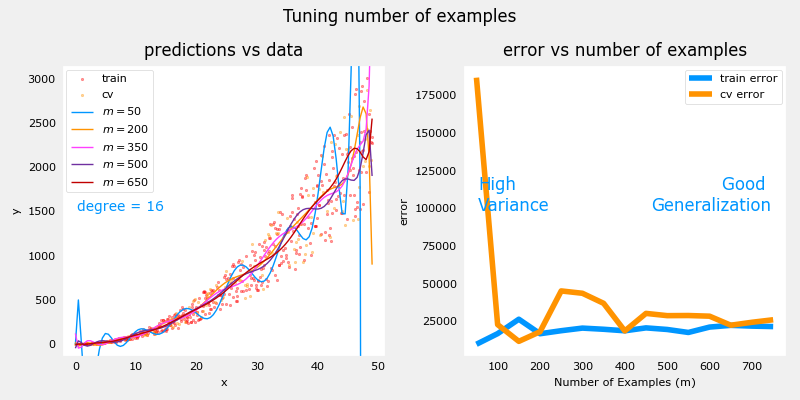

In [18]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

The above plots show that when a model has high variance and is overfitting, adding more examples improves performance. Note the curves on the left plot. The final curve with the highest value of $m$ is a smooth curve that is in the center of the data. On the right, as the number of examples increases, the performance of the training set and cross-validation set converge to similar values. Note that the curves are not as smooth as one might see in a lecture. That is to be expected. The trend remains clear: more data improves generalization. 

> Note that adding more examples when the model has high bias (underfitting) does not improve performance.


<a name="4"></a>
## 4 - Evaluating a Learning Algorithm (Neural Network)
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

Above, you tuned aspects of a polynomial regression model. Here, you will work with a neural network model. Let's start by creating a classification data set. 

<a name="4.1"></a>
### 4.1 Data Set
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

Run the cell below to generate a data set and split it into training, cross-validation (CV) and test sets. In this example, we're increasing the percentage of cross-validation data points for emphasis.  

In [19]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


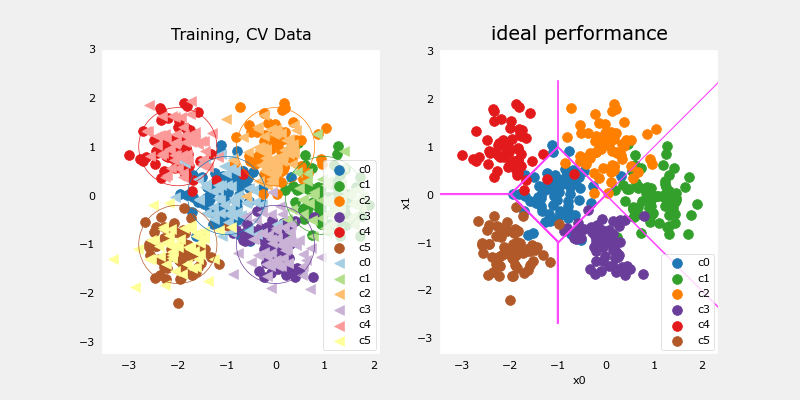

In [20]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

Above, you can see the data on the left. There are six clusters identified by color. Both training points (dots) and cross-validataion points (triangles) are shown. The interesting points are those that fall in ambiguous locations where either cluster might consider them members. What would you expect a neural network model to do? What would be an example of overfitting? underfitting?  
On the right is an example of an 'ideal' model, or a model one might create knowing the source of the data. The lines represent 'equal distance' boundaries where the distance between center points is equal. It's worth noting that this model would "misclassify" roughly 8% of the total data set.

<a name="4.2"></a>
### 4.2 Evaluating categorical model by calculating classification error
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

The evaluation function for categorical models used here is simply the fraction of incorrect predictions:  
$$ J_{cv} =\frac{1}{m}\sum_{i=0}^{m-1} 
\begin{cases}
    1, & \text{if $\hat{y}^{(i)} \neq y^{(i)}$}\\
    0, & \text{otherwise}
\end{cases}
$$

<a name="ex02"></a>
### Exercise 2
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

Below, complete the routine to calculate classification error. Note, in this lab, target values are the index of the category and are not [one-hot encoded](https://en.wikipedia.org/wiki/One-hot).

In [22]:
# UNQ_C2
# GRADED CELL: eval_cat_err
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhat[i] != y[i]:    # @REPLACE
            incorrect += 1     # @REPLACE
    cerr = incorrect/m         # @REPLACE
    return(cerr) 

In [23]:
y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.250" )

# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST

categorization error 0.333, expected:0.333
categorization error 0.250, expected:0.250
 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
```python
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhat[i] != y[i]:    # @REPLACE
            incorrect += 1     # @REPLACE
    cerr = incorrect/m         # @REPLACE
    return(cerr)                                    
``` 

<a name="5"></a>
## 5 - Model Complexity
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

Below, you will build two models. A complex model and a simple model. You will evaluate the models to determine if they are likely to overfit or underfit.

###  5.1 Complex model

<a name="ex03"></a>
### Exercise 3
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

Below, compose a three-layer model:
* Dense layer with 120 units, relu activation
* Dense layer with 40 units, relu activation
* Dense layer with 6 units and a linear activation (not softmax)  
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [24]:
# UNQ_C3
# GRADED CELL: model
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        Dense(120, activation = 'relu', name = "L1"),      
        Dense(40, activation = 'relu', name = "L2"),         
        Dense(classes, activation = 'linear', name = "L3")  
    ], name="Complex"
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),          
    optimizer=tf.keras.optimizers.Adam(0.01),   
)

model.fit(
    X_train,y_train,
    epochs=1000
)        

Epoch 1/1000
13/13 [==============================] - 3s 10ms/step - loss: 1.0976
Epoch 2/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3791
Epoch 3/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3044
Epoch 4/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2780
Epoch 5/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2722
Epoch 6/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2864
Epoch 7/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2447
Epoch 8/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2370
Epoch 9/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2432
Epoch 10/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2056
Epoch 11/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2246
Epoch 12/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2147
Epoch 13/1000
13/13 [===

Epoch 101/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1567
Epoch 102/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1524
Epoch 103/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1741
Epoch 104/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1499
Epoch 105/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1377
Epoch 106/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1422
Epoch 107/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1469
Epoch 108/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1337
Epoch 109/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1321
Epoch 110/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1323
Epoch 111/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1369
Epoch 112/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1397
Epoc

13/13 [==============================] - 0s 4ms/step - loss: 0.0796
Epoch 298/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0681
Epoch 299/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0678
Epoch 300/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0657
Epoch 301/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0607
Epoch 302/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0681
Epoch 303/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0715
Epoch 304/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0523
Epoch 305/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0602
Epoch 306/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0741
Epoch 307/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0672
Epoch 308/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0696
Epoch 309/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0300
Epoch 494/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0341
Epoch 495/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0335
Epoch 496/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0361
Epoch 497/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0399
Epoch 498/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0326
Epoch 499/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0307
Epoch 500/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0313
Epoch 501/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0385
Epoch 502/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0409
Epoch 503/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0506
Epoch 504/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0713
Epoch 505/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.1106
Epoch 690/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1318
Epoch 691/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0737
Epoch 692/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0779
Epoch 693/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1001
Epoch 694/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1262
Epoch 695/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0987
Epoch 696/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0892
Epoch 697/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0889
Epoch 698/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0519
Epoch 699/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0794
Epoch 700/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0390
Epoch 701/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.0752
Epoch 886/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0682
Epoch 887/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1023
Epoch 888/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0998
Epoch 889/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0564
Epoch 890/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0260
Epoch 891/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0429
Epoch 892/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0288
Epoch 893/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0261
Epoch 894/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0245
Epoch 895/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0209
Epoch 896/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0211
Epoch 897/1000
13/1

In [25]:
# BEGIN UNIT TEST
model.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0302
Epoch 2/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0202
Epoch 3/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0221
Epoch 4/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0198
Epoch 5/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.0193
Epoch 6/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0185
Epoch 7/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0183
Epoch 8/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0181
Epoch 9/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0173
Epoch 10/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0170
Epoch 11/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0176
Epoch 12/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0186
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 4ms/step - loss: 0.0147
Epoch 102/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0138
Epoch 103/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 104/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 105/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 106/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 107/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0160
Epoch 108/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0134
Epoch 109/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 110/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 111/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 112/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 113/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0264
Epoch 298/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0264
Epoch 299/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0267
Epoch 300/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0318
Epoch 301/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0232
Epoch 302/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0337
Epoch 303/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0277
Epoch 304/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0250
Epoch 305/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0372
Epoch 306/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0360
Epoch 307/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0456
Epoch 308/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0290
Epoch 309/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.0120
Epoch 494/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 495/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 496/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 497/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 498/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 499/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0144
Epoch 500/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0160
Epoch 501/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0210
Epoch 502/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0149
Epoch 503/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0114
Epoch 504/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 505/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.2284
Epoch 690/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2024
Epoch 691/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0865
Epoch 692/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0378
Epoch 693/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0528
Epoch 694/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0533
Epoch 695/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0406
Epoch 696/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0654
Epoch 697/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0472
Epoch 698/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0742
Epoch 699/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0315
Epoch 700/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0235
Epoch 701/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.0460
Epoch 886/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0327
Epoch 887/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0281
Epoch 888/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0159
Epoch 889/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0210
Epoch 890/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0207
Epoch 891/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 892/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0174
Epoch 893/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 894/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0131
Epoch 895/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0152
Epoch 896/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 897/1000
13/1

In [26]:
# BEGIN UNIT TEST
model.summary()

model_test(model, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "Complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 120)               360       
                                                                 
 L2 (Dense)                  (None, 40)                4840      
                                                                 
 L3 (Dense)                  (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Complex"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model = Sequential(
    [
        Dense(120, activation = 'relu', name = "L1"),      
        Dense(40, activation = 'relu', name = "L2"),         
        Dense(classes, activation = 'linear', name = "L3")  
    ], name="Complex"
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),          
    optimizer=tf.keras.optimizers.Adam(0.01),   
)

model.fit(
    X_train,y_train,
    epochs=1000
)                                  
``` 

1082/1082 [==============================] - 3s 3ms/step


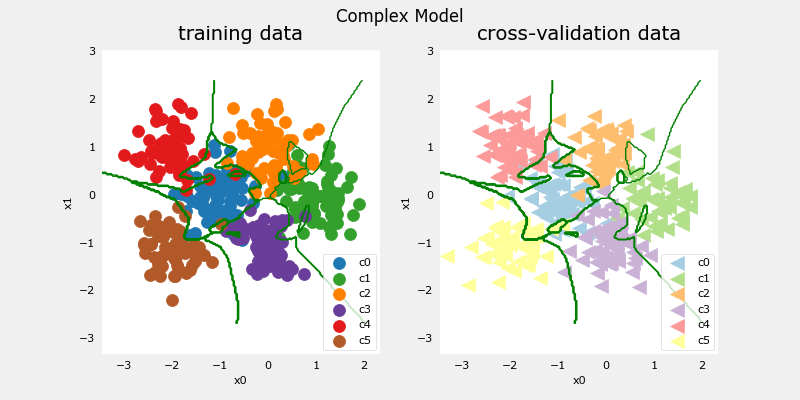

In [27]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

This model has worked very hard to capture outliers of each category. As a result, it has miscategorized some of the cross-validation data. Let's calculate the classification error.

In [28]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

10/10 [==============================] - 0s 3ms/step
categorization error, training, complex model: 0.005
categorization error, cv,       complex model: 0.122


<a name="5.1"></a>
### 5.1 Simple model
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

Now, let's try a simple model

<a name="ex04"></a>
### Exercise 4
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

Below, compose a two-layer model:
* Dense layer with 6 units, relu activation
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [29]:
# UNQ_C4
# GRADED CELL: model_s

tf.random.set_seed(1234)
model_s = Sequential(
    [
        Dense(6, activation = 'relu', name="L1"),            # @REPLACE
        Dense(classes, activation = 'linear', name="L2")     # @REPLACE
    ], name = "Simple"
)
model_s.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),     # @REPLACE
    optimizer=tf.keras.optimizers.Adam(0.01),     # @REPLACE
)

model_s.fit(
    X_train,y_train,
    epochs=1000
)

Epoch 1/1000
13/13 [==============================] - 1s 5ms/step - loss: 1.9290
Epoch 2/1000
13/13 [==============================] - 0s 5ms/step - loss: 1.6414
Epoch 3/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.4270
Epoch 4/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.2155
Epoch 5/1000
13/13 [==============================] - 0s 5ms/step - loss: 1.0387
Epoch 6/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.8838
Epoch 7/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.7655
Epoch 8/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.6590
Epoch 9/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5780
Epoch 10/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5130
Epoch 11/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4583
Epoch 12/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4181
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 3ms/step - loss: 0.2036
Epoch 102/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2050
Epoch 103/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2079
Epoch 104/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2022
Epoch 105/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2006
Epoch 106/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2015
Epoch 107/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2007
Epoch 108/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2006
Epoch 109/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2025
Epoch 110/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2017
Epoch 111/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2007
Epoch 112/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2020
Epoch 113/1000
13/1

13/13 [==============================] - 0s 6ms/step - loss: 0.1948
Epoch 298/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1937
Epoch 299/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1920
Epoch 300/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1931
Epoch 301/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1936
Epoch 302/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1959
Epoch 303/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1920
Epoch 304/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1971
Epoch 305/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1946
Epoch 306/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1920
Epoch 307/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1926
Epoch 308/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1934
Epoch 309/1000
13/1

13/13 [==============================] - 0s 5ms/step - loss: 0.1897
Epoch 494/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1875
Epoch 495/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1875
Epoch 496/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1915
Epoch 497/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1866
Epoch 498/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1862
Epoch 499/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1883
Epoch 500/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1861
Epoch 501/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1891
Epoch 502/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1883
Epoch 503/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1893
Epoch 504/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1859
Epoch 505/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1847
Epoch 690/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1836
Epoch 691/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1851
Epoch 692/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1843
Epoch 693/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1853
Epoch 694/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1849
Epoch 695/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1853
Epoch 696/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1837
Epoch 697/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.1864
Epoch 698/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1852
Epoch 699/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1837
Epoch 700/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1857
Epoch 701/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1824
Epoch 886/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1825
Epoch 887/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1830
Epoch 888/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1838
Epoch 889/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1819
Epoch 890/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1849
Epoch 891/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1826
Epoch 892/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1834
Epoch 893/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1828
Epoch 894/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1837
Epoch 895/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1832
Epoch 896/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1845
Epoch 897/1000
13/1

In [30]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# BEGIN UNIT TEST
model_s.fit(
    X_train,y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1842
Epoch 2/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1793
Epoch 3/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1869
Epoch 4/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1836
Epoch 5/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1830
Epoch 6/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1831
Epoch 7/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1852
Epoch 8/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.1818
Epoch 9/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1801
Epoch 10/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.1804
Epoch 11/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1786
Epoch 12/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1875
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 4ms/step - loss: 0.1830
Epoch 102/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1847
Epoch 103/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1840
Epoch 104/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1810
Epoch 105/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1788
Epoch 106/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1788
Epoch 107/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1792
Epoch 108/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1787
Epoch 109/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1827
Epoch 110/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1816
Epoch 111/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1796
Epoch 112/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1823
Epoch 113/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1786
Epoch 298/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1779
Epoch 299/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1760
Epoch 300/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1784
Epoch 301/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1793
Epoch 302/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1821
Epoch 303/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1773
Epoch 304/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1808
Epoch 305/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1811
Epoch 306/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1782
Epoch 307/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1771
Epoch 308/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1798
Epoch 309/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.1784
Epoch 494/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1760
Epoch 495/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1761
Epoch 496/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1804
Epoch 497/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1754
Epoch 498/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1743
Epoch 499/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1760
Epoch 500/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1741
Epoch 501/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1766
Epoch 502/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1752
Epoch 503/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1770
Epoch 504/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1731
Epoch 505/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1737
Epoch 690/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1724
Epoch 691/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1747
Epoch 692/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1729
Epoch 693/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1746
Epoch 694/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1747
Epoch 695/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1754
Epoch 696/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1730
Epoch 697/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1757
Epoch 698/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1749
Epoch 699/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1727
Epoch 700/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1755
Epoch 701/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1739
Epoch 886/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1729
Epoch 887/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1734
Epoch 888/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1754
Epoch 889/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1725
Epoch 890/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1759
Epoch 891/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1746
Epoch 892/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1736
Epoch 893/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1726
Epoch 894/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1745
Epoch 895/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1735
Epoch 896/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1756
Epoch 897/1000
13/1

In [31]:
# BEGIN UNIT TEST
model_s.summary()

model_s_test(model_s, classes, X_train.shape[1])
# END UNIT TEST

Model: "Simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 6)                 18        
                                                                 
 L2 (Dense)                  (None, 6)                 42        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 6)                 18        
_________________________________________________________________
L2 (Dense)                   (None, 6)                 42        
=================================================================
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_s = Sequential(
    [
        Dense(6, activation = 'relu', name="L1"),            # @REPLACE
        Dense(classes, activation = 'linear', name="L2")     # @REPLACE
    ], name = "Simple"
)
model_s.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),     # @REPLACE
    optimizer=tf.keras.optimizers.Adam(0.01),     # @REPLACE
)

model_s.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 [==============================] - 3s 2ms/step


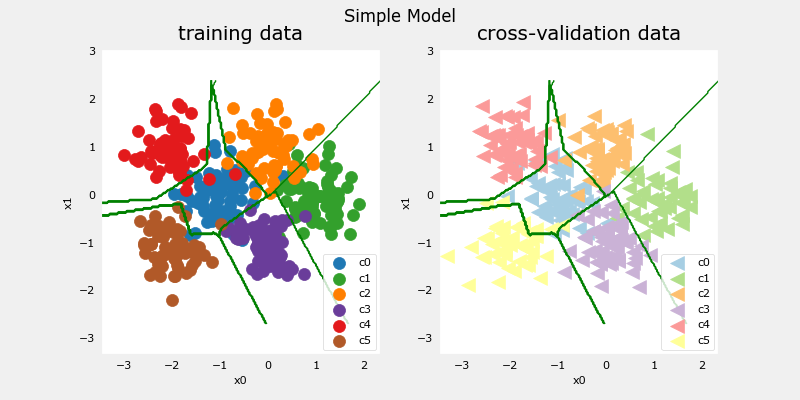

In [32]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

This simple models does pretty well. Let's calculate the classification error.

In [33]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

10/10 [==============================] - 0s 4ms/step
categorization error, training, simple model, 0.058, complex model: 0.005
categorization error, cv,       simple model, 0.091, complex model: 0.122


Our simple model has a little higher classification error on training data but does better on cross-validation data than the more complex model.

<a name="6"></a>
## 6 - Regularization
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

As in the case of polynomial regression, one can apply regularization to moderate the impact of a more complex model. Let's try this below.

<a name="ex05"></a>
### Exercise 5
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

Reconstruct your complex model, but this time include regularization.
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 40 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [34]:
# UNQ_C5
# GRADED CELL: model_r

tf.random.set_seed(1234)
model_r = Sequential(
    [
        Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L1"), 
        Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L2"),  
        Dense(classes, activation = 'linear', name="L3")  
    ], name="ComplexRegularized"
)
model_r.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.01),                             
)

model_r.fit(
    X_train,y_train,
    epochs=1000
)


Epoch 1/1000
13/13 [==============================] - 2s 5ms/step - loss: 4.4139
Epoch 2/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.6472
Epoch 3/1000
13/13 [==============================] - 0s 5ms/step - loss: 1.2768
Epoch 4/1000
13/13 [==============================] - 0s 5ms/step - loss: 1.0406
Epoch 5/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.9672
Epoch 6/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.9473
Epoch 7/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.9167
Epoch 8/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.8697
Epoch 9/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.8012
Epoch 10/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.7649
Epoch 11/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.7562
Epoch 12/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.7529
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 4ms/step - loss: 0.4975
Epoch 102/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4777
Epoch 103/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4718
Epoch 104/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4657
Epoch 105/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5127
Epoch 106/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4774
Epoch 107/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4650
Epoch 108/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4716
Epoch 109/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4602
Epoch 110/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4559
Epoch 111/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4601
Epoch 112/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4551
Epoch 113/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.3820
Epoch 298/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3987
Epoch 299/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3987
Epoch 300/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4330
Epoch 301/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4019
Epoch 302/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3948
Epoch 303/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3833
Epoch 304/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3796
Epoch 305/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3809
Epoch 306/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3892
Epoch 307/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3922
Epoch 308/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3957
Epoch 309/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.3491
Epoch 494/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3521
Epoch 495/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3486
Epoch 496/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3743
Epoch 497/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3950
Epoch 498/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3494
Epoch 499/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3421
Epoch 500/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3644
Epoch 501/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3573
Epoch 502/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3645
Epoch 503/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3872
Epoch 504/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3644
Epoch 505/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.4453
Epoch 690/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4135
Epoch 691/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3630
Epoch 692/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3488
Epoch 693/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3435
Epoch 694/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3447
Epoch 695/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3387
Epoch 696/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3338
Epoch 697/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3292
Epoch 698/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3491
Epoch 699/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3405
Epoch 700/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3487
Epoch 701/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.3723
Epoch 886/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3263
Epoch 887/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3248
Epoch 888/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3377
Epoch 889/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3356
Epoch 890/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3303
Epoch 891/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3424
Epoch 892/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3290
Epoch 893/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3394
Epoch 894/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3244
Epoch 895/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3958
Epoch 896/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3410
Epoch 897/1000
13/1

In [35]:
# BEGIN UNIT TEST
model_r.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3204
Epoch 2/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3272
Epoch 3/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3299
Epoch 4/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3212
Epoch 5/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3155
Epoch 6/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3245
Epoch 7/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3565
Epoch 8/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3153
Epoch 9/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3159
Epoch 10/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3074
Epoch 11/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3243
Epoch 12/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.3301
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 4ms/step - loss: 0.3351
Epoch 102/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3296
Epoch 103/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3320
Epoch 104/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3189
Epoch 105/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3319
Epoch 106/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3206
Epoch 107/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3606
Epoch 108/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4007
Epoch 109/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3509
Epoch 110/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3419
Epoch 111/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3235
Epoch 112/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3237
Epoch 113/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.3092
Epoch 298/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3358
Epoch 299/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3491
Epoch 300/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3801
Epoch 301/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3500
Epoch 302/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3266
Epoch 303/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3169
Epoch 304/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3195
Epoch 305/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3217
Epoch 306/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3224
Epoch 307/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3293
Epoch 308/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3423
Epoch 309/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.3057
Epoch 494/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3127
Epoch 495/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3076
Epoch 496/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3375
Epoch 497/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3510
Epoch 498/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3052
Epoch 499/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3017
Epoch 500/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3291
Epoch 501/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3199
Epoch 502/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3234
Epoch 503/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3488
Epoch 504/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3188
Epoch 505/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.3663
Epoch 690/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3338
Epoch 691/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3186
Epoch 692/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3252
Epoch 693/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3149
Epoch 694/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3284
Epoch 695/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3136
Epoch 696/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3124
Epoch 697/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3052
Epoch 698/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3225
Epoch 699/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3135
Epoch 700/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3174
Epoch 701/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3355
Epoch 886/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3067
Epoch 887/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3001
Epoch 888/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3129
Epoch 889/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3019
Epoch 890/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3439
Epoch 891/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3043
Epoch 892/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3033
Epoch 893/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3115
Epoch 894/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3143
Epoch 895/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3577
Epoch 896/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3216
Epoch 897/1000
13/1

In [36]:
# BEGIN UNIT TEST
model_r.summary()

model_r_test(model_r, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "ComplexRegularized"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 120)               360       
                                                                 
 L2 (Dense)                  (None, 40)                4840      
                                                                 
 L3 (Dense)                  (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
ddd
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "ComplexRegularized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_r = Sequential(
    [
        Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L1"), 
        Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L2"),  
        Dense(classes, activation = 'linear', name="L3")  
    ], name="ComplexRegularized"
)
model_r.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.01),                             
)

model_r.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 [==============================] - 3s 3ms/step


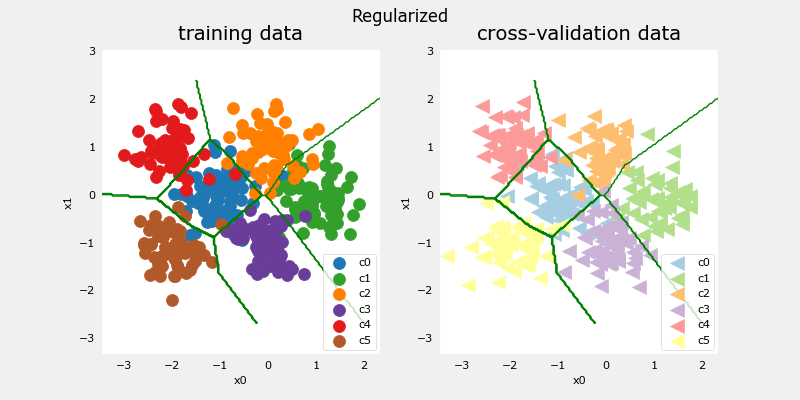

In [37]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

The results look very similar to the 'ideal' model. Let's check classification error.

In [38]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

3/3 [==============================] - 0s 6ms/step
categorization error, training, regularized: 0.080, simple model, 0.058, complex model: 0.005
categorization error, cv,       regularized: 0.069, simple model, 0.091, complex model: 0.122


The simple model is a bit better in the training set than the regularized model but worse in the cross validation set.

<a name="7"></a>
## 7 - Iterate to find optimal regularization value
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

As you did in linear regression, you can try many regularization values. This code takes several minutes to run. If you have time, you can run it and check the results. If not, you have completed the graded parts of the assignment!

In [39]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)

for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")


Epoch 1/1000
13/13 [==============================] - 2s 4ms/step - loss: 0.9645
Epoch 2/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3995
Epoch 3/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3092
Epoch 4/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2831
Epoch 5/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2781
Epoch 6/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2903
Epoch 7/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2384
Epoch 8/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2340
Epoch 9/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2413
Epoch 10/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2006
Epoch 11/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2160
Epoch 12/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2110
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 4ms/step - loss: 0.1568
Epoch 102/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1553
Epoch 103/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1858
Epoch 104/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1617
Epoch 105/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1459
Epoch 106/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1389
Epoch 107/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.1456
Epoch 108/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1410
Epoch 109/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1388
Epoch 110/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1330
Epoch 111/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1377
Epoch 112/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1450
Epoch 113/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.0812
Epoch 298/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1048
Epoch 299/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0757
Epoch 300/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0690
Epoch 301/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1108
Epoch 302/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1123
Epoch 303/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1290
Epoch 304/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0823
Epoch 305/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0712
Epoch 306/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0754
Epoch 307/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0662
Epoch 308/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0645
Epoch 309/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.0258
Epoch 494/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0285
Epoch 495/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0293
Epoch 496/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0310
Epoch 497/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0258
Epoch 498/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0339
Epoch 499/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0443
Epoch 500/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0347
Epoch 501/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0446
Epoch 502/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0355
Epoch 503/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0323
Epoch 504/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0348
Epoch 505/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0354
Epoch 690/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0329
Epoch 691/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0305
Epoch 692/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0239
Epoch 693/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0286
Epoch 694/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0276
Epoch 695/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0322
Epoch 696/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0276
Epoch 697/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0282
Epoch 698/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0255
Epoch 699/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0245
Epoch 700/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0213
Epoch 701/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.0190
Epoch 886/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0202
Epoch 887/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0191
Epoch 888/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0174
Epoch 889/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0182
Epoch 890/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 891/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 892/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 893/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0147
Epoch 894/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0149
Epoch 895/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 896/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 897/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2504
Epoch 83/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2351
Epoch 84/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2398
Epoch 85/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2561
Epoch 86/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2293
Epoch 87/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2296
Epoch 88/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2399
Epoch 89/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2370
Epoch 90/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2344
Epoch 91/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2248
Epoch 92/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2220
Epoch 93/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2248
Epoch 94/1000
13/13 [=========

13/13 [==============================] - 0s 3ms/step - loss: 0.2289
Epoch 182/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2162
Epoch 183/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2141
Epoch 184/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2132
Epoch 185/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2108
Epoch 186/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2074
Epoch 187/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2108
Epoch 188/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2112
Epoch 189/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2073
Epoch 190/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2145
Epoch 191/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2221
Epoch 192/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2127
Epoch 193/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1858
Epoch 378/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1883
Epoch 379/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1866
Epoch 380/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1865
Epoch 381/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1931
Epoch 382/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1982
Epoch 383/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2045
Epoch 384/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1992
Epoch 385/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1879
Epoch 386/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1858
Epoch 387/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1858
Epoch 388/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1889
Epoch 389/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1765
Epoch 574/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1755
Epoch 575/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1689
Epoch 576/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1680
Epoch 577/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1737
Epoch 578/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1803
Epoch 579/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1699
Epoch 580/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1771
Epoch 581/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1744
Epoch 582/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1636
Epoch 583/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1711
Epoch 584/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1848
Epoch 585/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1622
Epoch 770/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1624
Epoch 771/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1683
Epoch 772/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1662
Epoch 773/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1706
Epoch 774/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1758
Epoch 775/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1713
Epoch 776/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1636
Epoch 777/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1664
Epoch 778/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1660
Epoch 779/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1642
Epoch 780/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1653
Epoch 781/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.1663
Epoch 966/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1571
Epoch 967/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1761
Epoch 968/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1788
Epoch 969/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1710
Epoch 970/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1702
Epoch 971/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1616
Epoch 972/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1620
Epoch 973/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1561
Epoch 974/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1565
Epoch 975/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1546
Epoch 976/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1521
Epoch 977/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2814
Epoch 164/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2936
Epoch 165/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2844
Epoch 166/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2761
Epoch 167/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2818
Epoch 168/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2857
Epoch 169/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2789
Epoch 170/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2810
Epoch 171/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2728
Epoch 172/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2625
Epoch 173/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2832
Epoch 174/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2866
Epoch 175/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2523
Epoch 360/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2769
Epoch 361/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2498
Epoch 362/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2834
Epoch 363/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2793
Epoch 364/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2612
Epoch 365/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2576
Epoch 366/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2638
Epoch 367/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2717
Epoch 368/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2561
Epoch 369/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2548
Epoch 370/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2521
Epoch 371/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2459
Epoch 556/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2296
Epoch 557/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2306
Epoch 558/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2460
Epoch 559/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2548
Epoch 560/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2564
Epoch 561/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2384
Epoch 562/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2629
Epoch 563/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2323
Epoch 564/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2422
Epoch 565/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2382
Epoch 566/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2448
Epoch 567/1000
13/1

13/13 [==============================] - 0s 7ms/step - loss: 0.2333
Epoch 752/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2451
Epoch 753/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2243
Epoch 754/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2402
Epoch 755/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2344
Epoch 756/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2427
Epoch 757/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2450
Epoch 758/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2317
Epoch 759/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2295
Epoch 760/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2375
Epoch 761/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2414
Epoch 762/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2357
Epoch 763/1000
13/1

13/13 [==============================] - 0s 7ms/step - loss: 0.2363
Epoch 948/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2363
Epoch 949/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2304
Epoch 950/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2215
Epoch 951/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2282
Epoch 952/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2476
Epoch 953/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2316
Epoch 954/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2422
Epoch 955/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2278
Epoch 956/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2315
Epoch 957/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2360
Epoch 958/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2483
Epoch 959/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.3597
Epoch 146/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3568
Epoch 147/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3866
Epoch 148/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3701
Epoch 149/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3573
Epoch 150/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3581
Epoch 151/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3558
Epoch 152/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3530
Epoch 153/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3759
Epoch 154/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3575
Epoch 155/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3623
Epoch 156/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3639
Epoch 157/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.3283
Epoch 342/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3329
Epoch 343/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3226
Epoch 344/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3194
Epoch 345/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3186
Epoch 346/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3252
Epoch 347/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3400
Epoch 348/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3526
Epoch 349/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3127
Epoch 350/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3365
Epoch 351/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3163
Epoch 352/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3392
Epoch 353/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3700
Epoch 538/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.3247
Epoch 539/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3045
Epoch 540/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3214
Epoch 541/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3299
Epoch 542/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3370
Epoch 543/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3334
Epoch 544/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3185
Epoch 545/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3115
Epoch 546/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3209
Epoch 547/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3403
Epoch 548/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3154
Epoch 549/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2992
Epoch 734/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3271
Epoch 735/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3114
Epoch 736/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3170
Epoch 737/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3311
Epoch 738/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3033
Epoch 739/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3101
Epoch 740/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3113
Epoch 741/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3195
Epoch 742/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3503
Epoch 743/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3049
Epoch 744/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2932
Epoch 745/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3182
Epoch 930/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3264
Epoch 931/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3131
Epoch 932/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3069
Epoch 933/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3045
Epoch 934/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3321
Epoch 935/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2991
Epoch 936/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2997
Epoch 937/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2982
Epoch 938/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3155
Epoch 939/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3021
Epoch 940/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3007
Epoch 941/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.6136
Epoch 29/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6015
Epoch 30/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6215
Epoch 31/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6178
Epoch 32/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.6326
Epoch 33/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.6186
Epoch 34/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6663
Epoch 35/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.6377
Epoch 36/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6104
Epoch 37/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5844
Epoch 38/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5674
Epoch 39/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5676
Epoch 40/1000
13/13 [=========

13/13 [==============================] - 0s 3ms/step - loss: 0.4300
Epoch 226/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4139
Epoch 227/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4237
Epoch 228/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3871
Epoch 229/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4020
Epoch 230/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4081
Epoch 231/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4044
Epoch 232/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4103
Epoch 233/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3917
Epoch 234/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3885
Epoch 235/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3882
Epoch 236/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3941
Epoch 237/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.3841
Epoch 422/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3959
Epoch 423/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3746
Epoch 424/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3739
Epoch 425/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3650
Epoch 426/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3625
Epoch 427/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3642
Epoch 428/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3730
Epoch 429/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3677
Epoch 430/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3582
Epoch 431/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3498
Epoch 432/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3567
Epoch 433/1000
13/1

13/13 [==============================] - 0s 5ms/step - loss: 0.3241
Epoch 618/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3693
Epoch 619/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3819
Epoch 620/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3766
Epoch 621/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3399
Epoch 622/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3432
Epoch 623/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3537
Epoch 624/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3496
Epoch 625/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3277
Epoch 626/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3340
Epoch 627/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3497
Epoch 628/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3638
Epoch 629/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.3248
Epoch 814/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3321
Epoch 815/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3300
Epoch 816/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3357
Epoch 817/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3531
Epoch 818/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3484
Epoch 819/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3241
Epoch 820/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3561
Epoch 821/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3817
Epoch 822/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3415
Epoch 823/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3398
Epoch 824/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3435
Epoch 825/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 1.0632
Epoch 10/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.0229
Epoch 11/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.9845
Epoch 12/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9671
Epoch 13/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9625
Epoch 14/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.9499
Epoch 15/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9034
Epoch 16/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.9103
Epoch 17/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9142
Epoch 18/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.8971
Epoch 19/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.8703
Epoch 20/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.8604
Epoch 21/1000
13/13 [=========

Epoch 109/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5769
Epoch 110/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5742
Epoch 111/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5708
Epoch 112/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.5609
Epoch 113/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5534
Epoch 114/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5519
Epoch 115/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5538
Epoch 116/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5572
Epoch 117/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5877
Epoch 118/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5868
Epoch 119/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5826
Epoch 120/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5715
Epoc

13/13 [==============================] - 0s 4ms/step - loss: 0.4482
Epoch 306/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4718
Epoch 307/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4578
Epoch 308/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4459
Epoch 309/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4578
Epoch 310/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4490
Epoch 311/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4421
Epoch 312/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4417
Epoch 313/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4497
Epoch 314/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4524
Epoch 315/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4472
Epoch 316/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4418
Epoch 317/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.4050
Epoch 502/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4275
Epoch 503/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4598
Epoch 504/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4518
Epoch 505/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4421
Epoch 506/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4542
Epoch 507/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4426
Epoch 508/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4019
Epoch 509/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4130
Epoch 510/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4093
Epoch 511/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4205
Epoch 512/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4180
Epoch 513/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3855
Epoch 698/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4008
Epoch 699/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3870
Epoch 700/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3766
Epoch 701/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3914
Epoch 702/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3803
Epoch 703/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3700
Epoch 704/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4016
Epoch 705/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3929
Epoch 706/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3965
Epoch 707/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4065
Epoch 708/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4030
Epoch 709/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.3837
Epoch 894/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3754
Epoch 895/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4171
Epoch 896/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3885
Epoch 897/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3858
Epoch 898/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3853
Epoch 899/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4125
Epoch 900/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3996
Epoch 901/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4311
Epoch 902/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4248
Epoch 903/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4181
Epoch 904/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3721
Epoch 905/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.6763
Epoch 91/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.6736
Epoch 92/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.6716
Epoch 93/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6632
Epoch 94/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6596
Epoch 95/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.6620
Epoch 96/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.6541
Epoch 97/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.6591
Epoch 98/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.6645
Epoch 99/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6833
Epoch 100/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.6933
Epoch 101/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.6906
Epoch 102/1000
13/13 [======

Epoch 189/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5640
Epoch 190/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5554
Epoch 191/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5744
Epoch 192/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5687
Epoch 193/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5583
Epoch 194/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5523
Epoch 195/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5538
Epoch 196/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5482
Epoch 197/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5619
Epoch 198/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5487
Epoch 199/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5584
Epoch 200/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5560
Epoc

13/13 [==============================] - 0s 5ms/step - loss: 0.4853
Epoch 386/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4710
Epoch 387/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4872
Epoch 388/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4948
Epoch 389/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4835
Epoch 390/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4702
Epoch 391/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4730
Epoch 392/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4765
Epoch 393/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4743
Epoch 394/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4753
Epoch 395/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4982
Epoch 396/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.5219
Epoch 397/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.4922
Epoch 582/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4729
Epoch 583/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4718
Epoch 584/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4486
Epoch 585/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4686
Epoch 586/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4811
Epoch 587/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4457
Epoch 588/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4554
Epoch 589/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4637
Epoch 590/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4480
Epoch 591/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4403
Epoch 592/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4305
Epoch 593/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.4571
Epoch 778/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4745
Epoch 779/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4302
Epoch 780/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4131
Epoch 781/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4376
Epoch 782/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4067
Epoch 783/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4202
Epoch 784/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4192
Epoch 785/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4022
Epoch 786/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4092
Epoch 787/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4162
Epoch 788/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4043
Epoch 789/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3945
Epoch 974/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3972
Epoch 975/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3866
Epoch 976/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3956
Epoch 977/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3984
Epoch 978/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3922
Epoch 979/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4089
Epoch 980/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4395
Epoch 981/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4239
Epoch 982/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4268
Epoch 983/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3953
Epoch 984/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4111
Epoch 985/1000
13/1

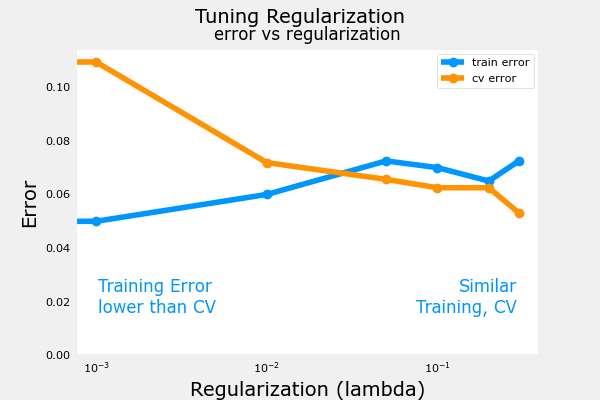

In [40]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

As regularization is increased, the performance of the model on the training and cross-validation data sets converge. For this data set and model, lambda > 0.01 seems to be a reasonable choice.

<a name="7.1"></a>
### 7.1 Test
<div style="text-align: right;"><a href="#toc" style="text-decoration:none;">↑ Table of Contents</a></div>

Let's try our optimized models on the test set and compare them to 'ideal' performance. 

3/3 [==============================] - 0s 7ms/step


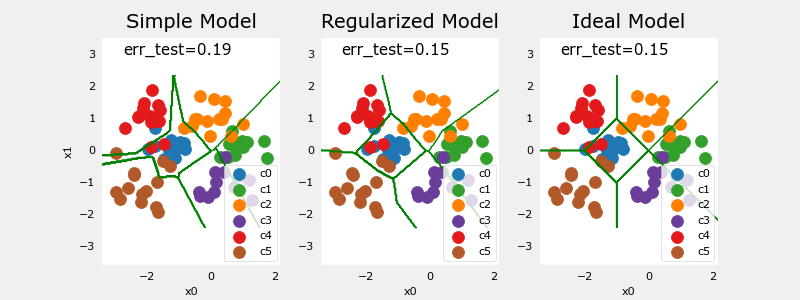

In [41]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)

Our test set is small and seems to have a number of outliers so classification error is high. However, the performance of our optimized models is comparable to ideal performance.